In [1]:
%matplotlib inline

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%pwd

'/home/fbutic/Documents/cancer-classification/research'

In [3]:
os.chdir("..")

In [4]:
%pwd

'/home/fbutic/Documents/cancer-classification'

In [8]:
def GetDataSetSize(path: Path):
    num_of_images = {}
    for folder in os.listdir(path):
        num_of_images[folder] = len(os.listdir(os.path.join(path, folder)))

    return num_of_images

train_set = GetDataSetSize("artifacts/data_ingestion/Data/train/")
val_set = GetDataSetSize("artifacts/data_ingestion/Data/valid/")
test_set = GetDataSetSize("artifacts/data_ingestion/Data/test/")

print(train_set)
print(val_set)
print(test_set)

{'adenocarcinoma': 195, 'normal': 148, 'squamous.cell.carcinoma': 155, 'large.cell.carcinoma': 115}
{'adenocarcinoma': 23, 'normal': 13, 'squamous.cell.carcinoma': 15, 'large.cell.carcinoma': 21}
{'adenocarcinoma': 120, 'normal': 54, 'squamous.cell.carcinoma': 90, 'large.cell.carcinoma': 51}


In [7]:
# Renaming the train and valid folder to have the same folder names as test (normal label names for folders)
# os.rename(source, dest)
os.rename("artifacts/data_ingestion/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/", "artifacts/data_ingestion/Data/train/adenocarcinoma")
os.rename("artifacts/data_ingestion/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/", "artifacts/data_ingestion/Data/train/large.cell.carcinoma")
os.rename("artifacts/data_ingestion/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/", "artifacts/data_ingestion/Data/train/squamous.cell.carcinoma")

os.rename("artifacts/data_ingestion/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib//", "artifacts/data_ingestion/Data/valid/adenocarcinoma")
os.rename("artifacts/data_ingestion/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa//", "artifacts/data_ingestion/Data/valid/large.cell.carcinoma")
os.rename("artifacts/data_ingestion/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa//", "artifacts/data_ingestion/Data/valid/squamous.cell.carcinoma")

In [9]:
print(train_set.keys(), val_set.keys(), test_set.keys())

dict_keys(['adenocarcinoma', 'normal', 'squamous.cell.carcinoma', 'large.cell.carcinoma']) dict_keys(['adenocarcinoma', 'normal', 'squamous.cell.carcinoma', 'large.cell.carcinoma']) dict_keys(['adenocarcinoma', 'normal', 'squamous.cell.carcinoma', 'large.cell.carcinoma'])


In [10]:
labels = list(test_set.keys())
labels

['adenocarcinoma', 'normal', 'squamous.cell.carcinoma', 'large.cell.carcinoma']

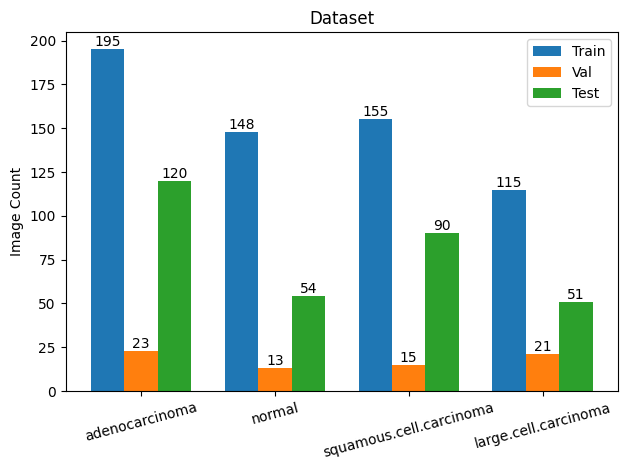

In [11]:
train_list = list(train_set.values())
valid_list = list(val_set.values())
test_list = list(test_set.values())

train_set
val_set
test_set

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()

bar1 = ax.bar(x - width, train_list, width, label="Train")
bar2 = ax.bar(x , valid_list, width, label="Val")
bar3 = ax.bar(x + width, test_list, width, label="Test")

ax.set_ylabel("Image Count")
ax.set_title("Dataset")
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(bar1)
ax.bar_label(bar2)
ax.bar_label(bar3)

fig.tight_layout()

In [69]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations
train_transforms = transforms.Compose([
    transforms.Resize((350, 350)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0.4, shear=0.2, scale=(0.8, 1.2)),  # Combined zoom and shear
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomVerticalFlip(),    # Vertical flip
    transforms.RandomRotation(0.4),     # Random rotation
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the dataset with ImageFolder
train_path = "artifacts/data_ingestion/Data/train/"
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True, num_workers=4)

print(f"Train loader size {len(train_dataset)}")
# Get the class-to-index mapping
class_to_idx = train_dataset.class_to_idx
print("Class to Index Mapping:", class_to_idx)

# Optionally, create a reverse mapping (index to class)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Index to Class Mapping:", idx_to_class)


Train loader size 613
Class to Index Mapping: {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
Index to Class Mapping: {0: 'adenocarcinoma', 1: 'large.cell.carcinoma', 2: 'normal', 3: 'squamous.cell.carcinoma'}


In [81]:
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    num_images = len(images)
    
    # Create a 3x3 grid
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))  
    # fig.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the width and height space between subplots
    fig.tight_layout()
    
    for i in range(num_images):
        ax = axs[i // 3, i % 3]  # Get the correct axis for the grid
        image = images[i].permute(1, 2, 0).numpy()  # Convert from tensor to numpy array and change dimension order
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        image = np.clip(image, 0, 1)  # Clip values to ensure they are between 0 and 1
        
        ax.imshow(image)
        ax.set_title("Label: {}".format(class_labels[labels[i].item()]), fontsize=10)
        ax.axis('off')

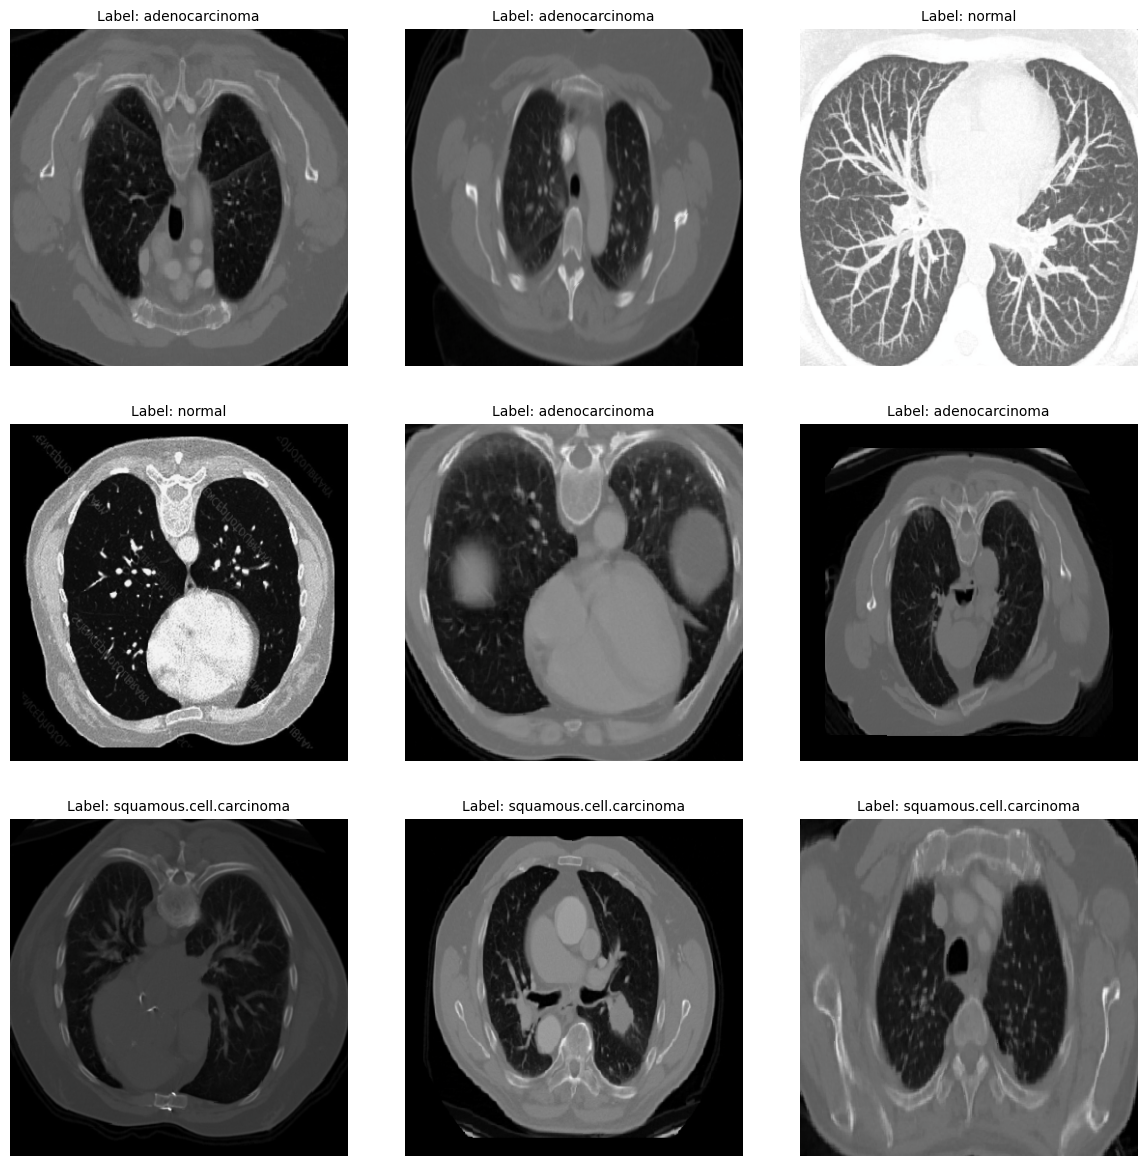

In [83]:
# Sample and plotting of 3 images with their respective labels from train_data
sample_images, sample_labels = next(iter(train_loader))
plot_sample_images(sample_images, sample_labels, train_dataset.class_to_idx)